# Concrete Strength Prediction Model in Keras (Part A) #

In [1]:
import keras
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras import activations
from tensorflow.keras.initializers import GlorotUniform

## Assignment Part A ##

Requirements:
1. Build a network with one hidden layer with 10 nodes and ReLU activation function
2. Use Adam optimizer and MSE (mean squared error) loss function
3. Randomly split the data into test / train using train_test_split function
4. Train the model for 50 epochs
5. Evaluate the model on the test data and compute the MSE between predicted concrete strength and actual concrete strength using MSE from Scikit-learn
6. Repeat steps 1-3, 50 times and create a list of 50 mean squared errors
7. Report the mean and standard deviation of the MSEs 

First, let's build a customizable model builder that can satisfy the requirements of the Assigment (different depth, shapes, activation functions)

We'll test the model builder function to ensure it produces a valid model structure then proceed to fulfill the requirements for Part A of the Assignment.

In [2]:
def build_model(n_inputs, hidden_layers=[10, 10, 10], n_out=1, activation=activations.relu):
    """
    builds a neural network using the depth and layer sizes provided by hidden_layers arg
    choose an activation function from the supported functions in activations
    
    when Keras initializes the weights and biases, they're set to random values, this can 
    cause each instance of the model to perform radically differently 
    
    As such, when we compare the results for different epochs, normalization, etc. the 
    weights and biases should be set using the same seed and initializer
    """
    initializer = GlorotUniform(seed=808)
    
    model = Sequential()
    for i, layer in enumerate(hidden_layers):
        if i == 0:
            # define the input shape based on n_inputs
            model.add(Dense(hidden_layers[i], activation=activation, input_shape=(n_inputs,), kernel_initializer=initializer))
        else:
            # base the input shape on the previous layer
            model.add(Dense(hidden_layers[i], activation=activation, input_shape=(hidden_layers[i-1],), kernel_initializer=initializer))
    
    # add our output layer
    model.add(Dense(n_out, input_shape=(hidden_layers[len(hidden_layers)-1],), kernel_initializer=initializer))
    
    # build the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [3]:
# test the model builder function and use model.summary to verify the shapes we expect from this test
test_model = build_model(6, [10, 20, 30, 100], n_out=1)

# show the model summary
test_model.summary()

# also, verify the input / output shapes since model.summary only shows outputs
for i, layer in enumerate(test_model.layers):
    print("Layer {0} input shape: {1} output shape:{2}".format(i+1, layer.input_shape[1], layer.output_shape[1]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                70        
                                                                 
 dense_1 (Dense)             (None, 20)                220       
                                                                 
 dense_2 (Dense)             (None, 30)                630       
                                                                 
 dense_3 (Dense)             (None, 100)               3100      
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                                 
Total params: 4,121
Trainable params: 4,121
Non-trainable params: 0
_________________________________________________________________
Layer 1 input shape: 6 output shape:10
Layer 2 input s

## Loading the concrete data into a pandas data frame ##

In [4]:
# load the concrete data into a pandas dataframe
data_df = pd.read_csv('https://cocl.us/concrete_data')

# get a random sample of the dataframe
data_df.sample(5)

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
525,359.0,19.0,141.0,154.0,10.9,942.0,801.0,3,25.12
996,152.6,238.7,0.0,200.0,6.3,1001.8,683.9,28,26.86
641,250.0,0.0,0.0,182.0,0.0,1100.0,820.0,7,12.73
486,387.0,20.0,94.0,157.0,13.9,938.0,845.0,28,46.68
284,181.4,0.0,167.0,169.6,7.6,1055.6,777.8,3,13.62


In [5]:
# determine the shape of the data (number of samples, columns, etc.)
data_df.shape

(1030, 9)

The shape of the data shows us there are 1030 samples and 9 columns. We can then use describe() to generate some summary stats for the columns. 

In [6]:
data_df.describe()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


Check if any null values exist

In [7]:
data_df.isnull().sum()

Cement                0
Blast Furnace Slag    0
Fly Ash               0
Water                 0
Superplasticizer      0
Coarse Aggregate      0
Fine Aggregate        0
Age                   0
Strength              0
dtype: int64

We separate the X input values and the labels/targets (Y values) from the dataset.

In [8]:
# just drop the label/target column and return a copy instead of a view
Xs = data_df.drop(['Strength'], axis=1).copy()

# get a copy of the label / target column
Ys = data_df['Strength'].copy()

In [9]:
Xs.sample(5)

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age
171,531.3,0.0,0.0,141.8,28.2,852.1,893.7,91
86,362.6,189.0,0.0,164.9,11.6,944.7,755.8,3
331,246.8,0.0,125.1,143.3,12.0,1086.8,800.9,28
194,194.7,0.0,100.5,165.6,7.5,1006.4,905.9,3
780,238.0,0.0,0.0,185.0,0.0,1118.0,789.0,28


In [10]:
Ys.sample(5)

847    52.82
67     30.28
921     9.74
416    15.61
138    49.90
Name: Strength, dtype: float64

## Implement Trial Testing for Part A ##

In [11]:
# implement a function that can satisfy the above requirements taking the prepared data to fit
# override the default params with the objective's requirements
def train_and_evaluate_baseline(Xs, Ys, n_trials=50, n_epochs=50, hidden_layers=[20, 20, 20]):
    """
    this function will implement the requirements for section A
    pass in the X and Y values and the number of trials to conduct
    """
    # placeholder to store the mse results from each iteration
    mse_results = np.zeros((n_trials)) 
    
    trial_histories = []
    
    for i in range(n_trials):
        
        # get the train/test split
        X_train, X_test, Y_train, Y_test = train_test_split(
            Xs.to_numpy(), 
            Ys.to_numpy(), 
            train_size=0.7)
        
        # get the input shape for the model (the number of columns)
        input_shape = X_train.shape[1]
        
        # build the model
        model = build_model(input_shape, hidden_layers, n_out=1)
        
        # fit the model
        history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=n_epochs, verbose=0)
        
        # save the train loss / validation loss from the model
        trial_histories.append(history.history)
        
        # get the predictions for the test data from the fitted model
        preds = model.predict(X_test, verbose=0)
        
        # get the mean squared error from the fitted model using the predictions
        mse = mean_squared_error(Y_test, preds)
        
        # add the mean squared error from the predictions vs ground truth to the results array
        mse_results[i] = mse
        
    return mse_results, trial_histories
        
        

For the first test, we are asked to train for 50 epochs, run 50 trials and one hidden layer of 10 nodes. 

In [12]:
# we get the results of the evaluations as a numpy array of MSE scores
mse_results, trial_histories = train_and_evaluate_baseline(Xs, Ys, n_trials = 50, n_epochs=50, hidden_layers=[10])

## Evaluate the Results ##

In [13]:
print("Got results from {} trials".format(len(mse_results)))
print("Trial results: \nMean of the MSEs: {0} Standard deviation of the MSEs {1}".format(mse_results.mean(), mse_results.std()))

Got results from 50 trials
Trial results: 
Mean of the MSEs: 520.9821628817358 Standard deviation of the MSEs 44.98304276206496


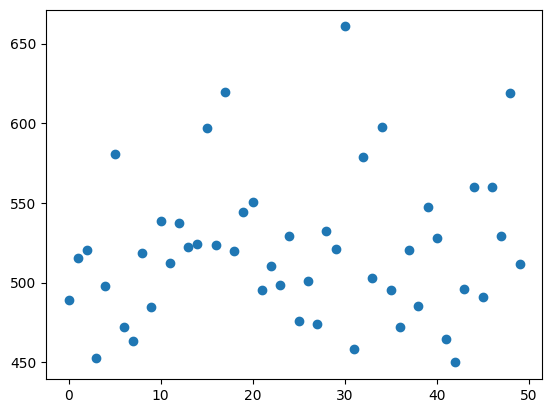

In [14]:
# visualize the distribution of MSEs across the 50 trials
import matplotlib.pyplot as plt
plt.scatter([i for i in range(len(mse_results))], mse_results)

It's usueful to review the training / validation loss curves to see if the model is overfit or if train/valid losses are diverging

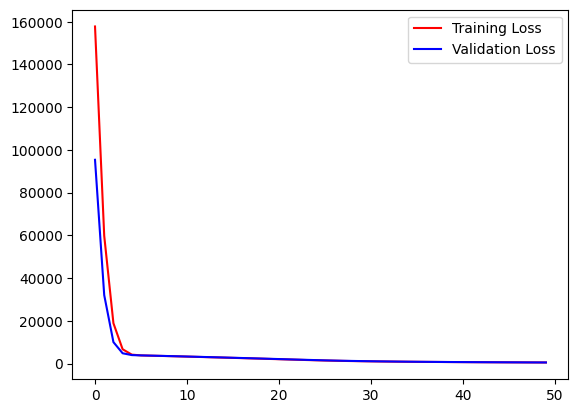

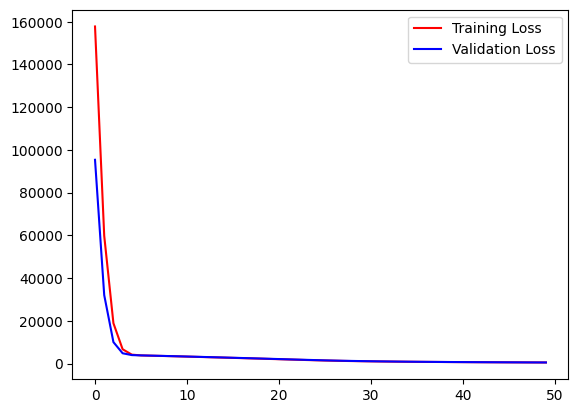

In [15]:
# plot a couple of the training / validation loss curves from the trial results
plt.plot(trial_histories[0]["loss"], color='red', label="Training Loss")
plt.plot(trial_histories[1]["val_loss"], color='blue', label="Validation Loss")
plt.legend()
plt.show()

plt.plot(trial_histories[0]["loss"], color='red', label="Training Loss")
plt.plot(trial_histories[1]["val_loss"], color='blue', label="Validation Loss")
plt.legend()
plt.show()